In [ ]:
!pip install fredapi xgboost seaborn

In [ ]:
from fredapi import Fred
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipython-input-3-1865618228.py:30: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


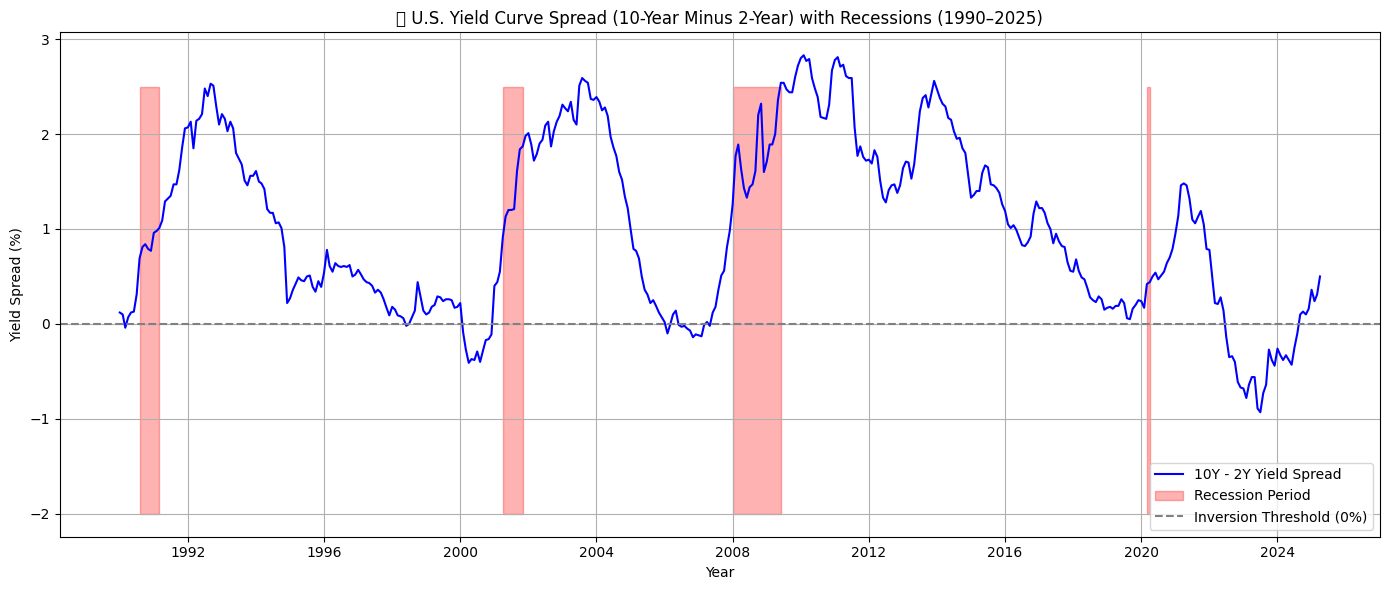

In [ ]:
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt

fred = Fred(api_key="03fde6b8b685d6c0b29161e2a4224ff0")

# Fetch yield data and recession markers
spread_10yr = fred.get_series('GS10', '1990-01-01', '2025-04-01')
spread_2yr = fred.get_series('GS2', '1990-01-01', '2025-04-01')
recession = fred.get_series('USREC', '1990-01-01', '2025-04-01')

# Compute spread
yield_spread = (spread_10yr - spread_2yr).to_frame(name='yield_spread')
yield_spread['recession'] = recession
yield_spread.index = pd.to_datetime(yield_spread.index)

# Resample to monthly average
yield_spread = yield_spread.resample('MS').mean()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(yield_spread.index, yield_spread['yield_spread'], label='10Y - 2Y Yield Spread', color='blue')
plt.fill_between(yield_spread.index, -2, 2.5, where=yield_spread['recession'] == 1, color='red', alpha=0.3, label='Recession Period')
plt.axhline(0, color='gray', linestyle='--', label='Inversion Threshold (0%)')
plt.title("📉 U.S. Yield Curve Spread (10-Year Minus 2-Year) with Recessions (1990–2025)")
plt.xlabel("Year")
plt.ylabel("Yield Spread (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
!pip install fredapi xgboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Connect to FRED
fred = Fred(api_key="03fde6b8b685d6c0b29161e2a4224ff0")

# Date range
start_date = '1990-01-01'
end_date = '2025-04-18'

# Load monthly macro data
df = pd.DataFrame({
    'fed_funds': fred.get_series('FEDFUNDS', start_date, end_date),
    'cpi': fred.get_series('CPIAUCSL', start_date, end_date),
    'ind_production': fred.get_series('INDPRO', start_date, end_date),
    'oil': fred.get_series('DCOILWTICO', start_date, end_date),
    'sentiment': fred.get_series('UMCSENT', start_date, end_date),
    'unemployment': fred.get_series('UNRATE', start_date, end_date),
    'tbill_3mo': fred.get_series('TB3MS', start_date, end_date)
}).resample('MS').mean()

# Add house price and credit (quarterly → monthly)
house = fred.get_series('USSTHPI', start_date, end_date).to_frame().rename(columns={0: 'house'})
credit = fred.get_series('QUSPAM770A', start_date, end_date).to_frame().rename(columns={0: 'credit'})
df = df.join(house.resample('MS').ffill()).join(credit.resample('MS').ffill())

# Yield spread (GS10 - GS2)
spread = fred.get_series('GS10', start_date, end_date) - fred.get_series('GS2', start_date, end_date)
df['yield_spread'] = spread.resample('MS').mean()
df.head()

,fed_funds,cpi,ind_production,oil,sentiment,unemployment,tbill_3mo,house,credit,yield_spread
1990-01-01,8.23,127.5,61.6352,22.863182,93.0,5.4,7.64,165.22,125.5,0.12
1990-02-01,8.24,128.0,62.1951,22.113000,89.5,5.3,7.74,165.22,125.5,0.10
1990-03-01,8.28,128.6,62.4916,20.387727,91.3,5.2,7.90,165.22,125.5,-0.04
1990-04-01,8.26,128.9,62.3511,18.425500,93.9,5.4,7.77,165.91,125.5,0.07
1990-05-01,8.18,129.1,62.5353,18.199545,90.6,5.4,7.74,165.91,125.5,0.12


In [ ]:
# Add lag, percent change, and rolling average features
for col in df.columns[:-1]:  # exclude yield_spread
    df[f'{col}_lag1'] = df[col].shift(1)
    df[f'{col}_change'] = df[col].pct_change()
    df[f'{col}_roll3'] = df[col].rolling(3).mean()

df.dropna(inplace=True)

# Define features and target
target = 'yield_spread'
features = df.drop(columns=['yield_spread']).columns
X = df[features]
y = df[target]

# Train the model
model_reg = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
model_reg.fit(X, y)

# Predict
y_pred = model_reg.predict(X)
df['predicted_yield_spread'] = y_pred

<ipython-input-7-9742eaa40caa>:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[f'{col}_change'] = df[col].pct_change()
<ipython-input-7-9742eaa40caa>:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[f'{col}_change'] = df[col].pct_change()
<ipython-input-7-9742eaa40caa>:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[f'{col}_change'] = df[col].pct_change()
<ipython-input-7-9742eaa40caa>:4: 

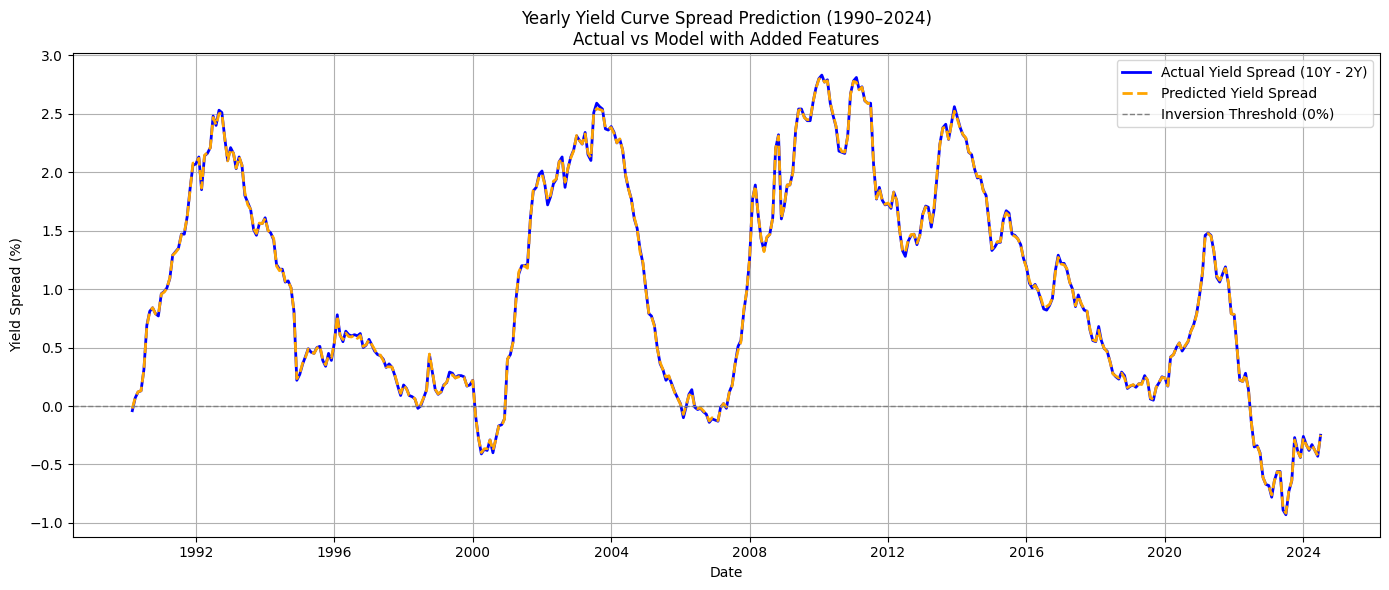

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['yield_spread'], label='Actual Yield Spread (10Y - 2Y)', color='blue', linewidth=2)
plt.plot(df.index, df['predicted_yield_spread'], label='Predicted Yield Spread', color='orange', linestyle='--', linewidth=2)
plt.axhline(0, color='gray', linestyle='--', linewidth=1, label='Inversion Threshold (0%)')
plt.title("Yearly Yield Curve Spread Prediction (1990–2024)\nActual vs Model with Added Features")
plt.xlabel("Date")
plt.ylabel("Yield Spread (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
rmse = mean_squared_error(y, y_pred) ** 0.5
r2 = r2_score(y, y_pred)
print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ R² Score: {r2:.4f}")

✅ RMSE: 0.0115
✅ R² Score: 0.9998


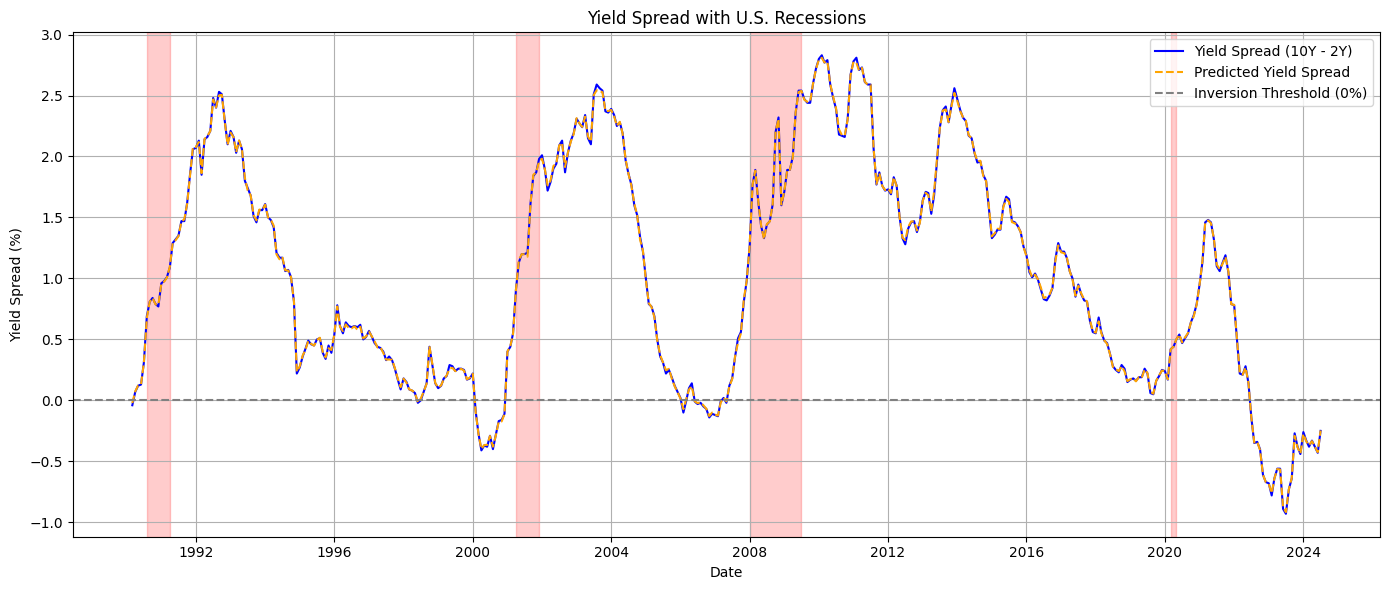

In [ ]:
import matplotlib.dates as mdates

# Download historical recession periods from FRED
recessions = fred.get_series('USREC', start_date, end_date)  # 1 = recession, 0 = not
df['recession'] = recessions

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['yield_spread'], label='Yield Spread (10Y - 2Y)', color='blue')
plt.plot(df.index, df['predicted_yield_spread'], label='Predicted Yield Spread', linestyle='--', color='orange')
plt.axhline(0, linestyle='--', color='gray', label='Inversion Threshold (0%)')

# Shade recession periods
for i in range(len(df) - 1):
    if df['recession'].iloc[i] == 0 and df['recession'].iloc[i + 1] == 1:
        start = df.index[i + 1]
    elif df['recession'].iloc[i] == 1 and df['recession'].iloc[i + 1] == 0:
        end = df.index[i + 1]
        plt.axvspan(start, end, color='red', alpha=0.2)

plt.title('Yield Spread with U.S. Recessions')
plt.xlabel('Date')
plt.ylabel('Yield Spread (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

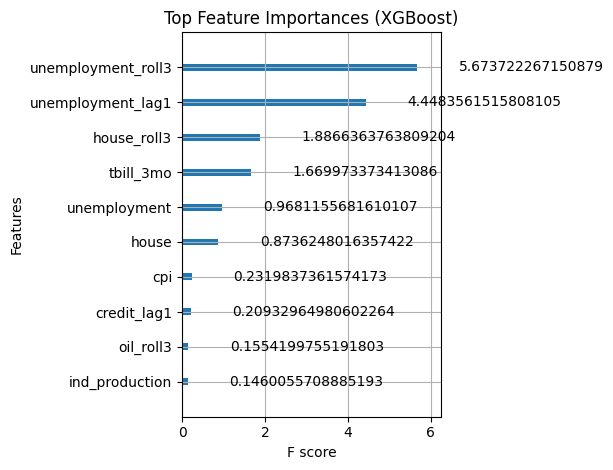

In [ ]:
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(model_reg, max_num_features=10, importance_type='gain')
plt.title('Top Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()

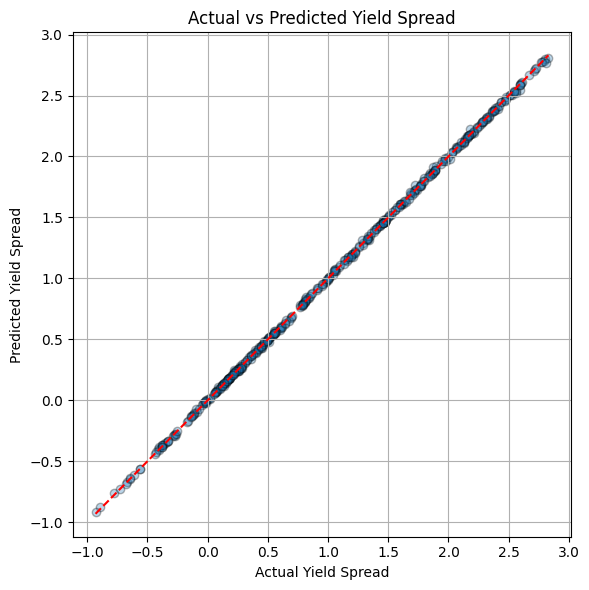

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred, alpha=0.3, edgecolors='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Yield Spread")
plt.ylabel("Predicted Yield Spread")
plt.title("Actual vs Predicted Yield Spread")
plt.grid(True)
plt.tight_layout()
plt.show()

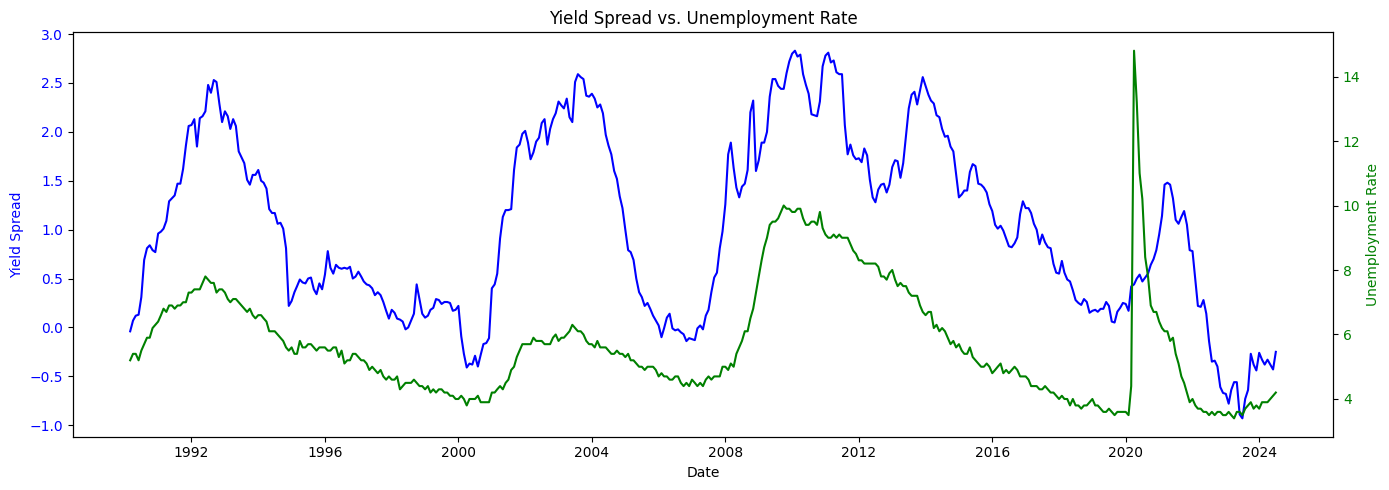

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 5))

ax1.set_xlabel("Date")
ax1.set_ylabel("Yield Spread", color='blue')
ax1.plot(df.index, df['yield_spread'], color='blue', label='Yield Spread')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel("Unemployment Rate", color='green')
ax2.plot(df.index, df['unemployment'], color='green', label='Unemployment Rate')
ax2.tick_params(axis='y', labelcolor='green')

plt.title("Yield Spread vs. Unemployment Rate")
fig.tight_layout()
plt.show()

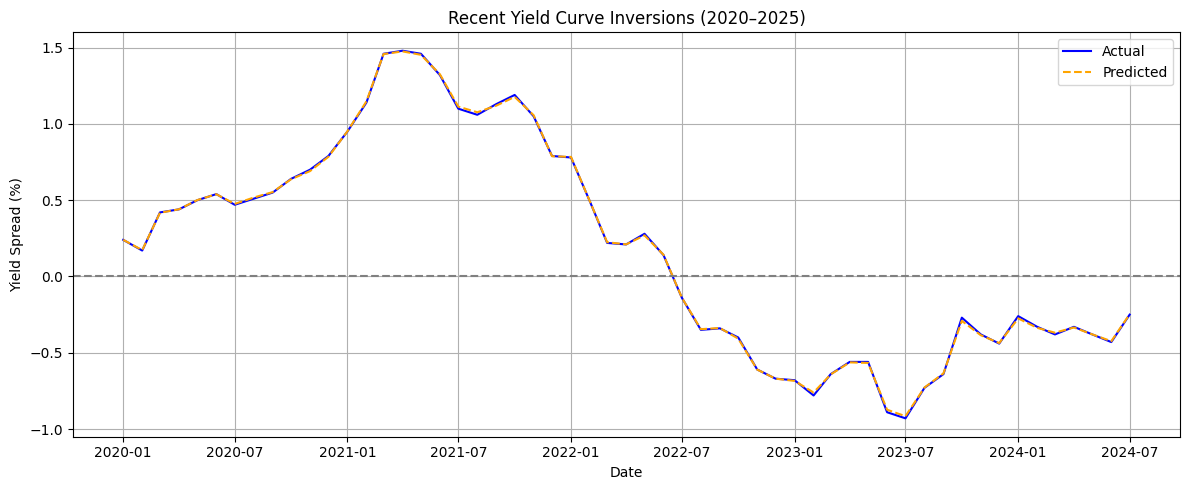

In [ ]:
recent_df = df[df.index >= '2020-01-01']

plt.figure(figsize=(12, 5))
plt.plot(recent_df.index, recent_df['yield_spread'], label='Actual', color='blue')
plt.plot(recent_df.index, recent_df['predicted_yield_spread'], label='Predicted', color='orange', linestyle='--')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Recent Yield Curve Inversions (2020–2025)")
plt.xlabel("Date")
plt.ylabel("Yield Spread (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

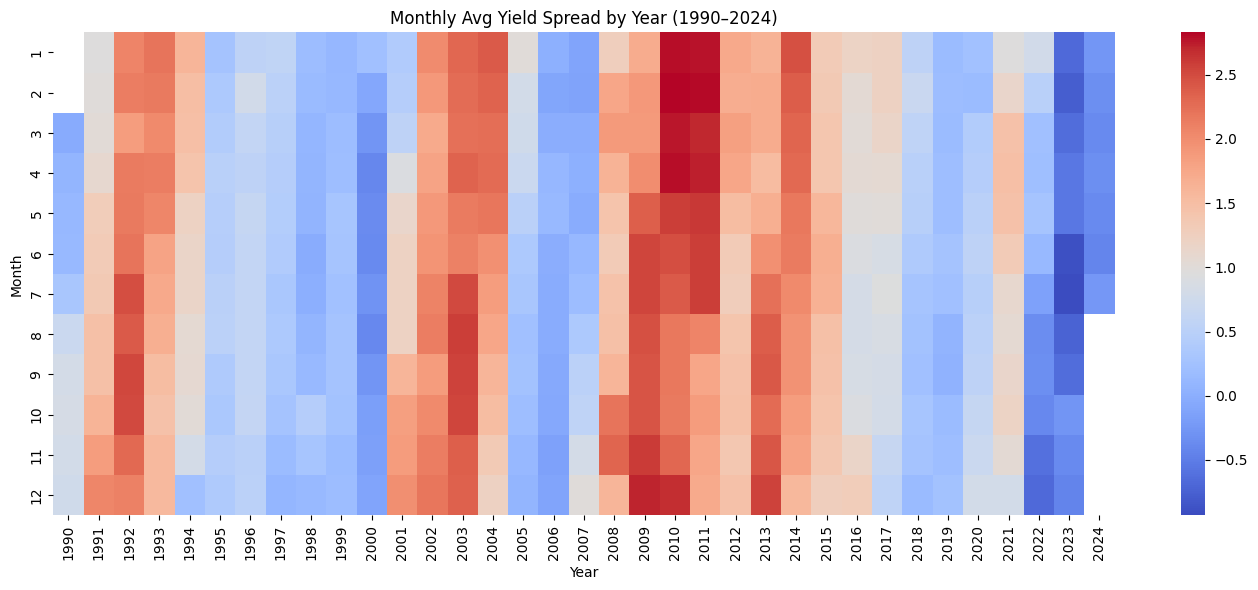

In [ ]:
df['year'] = df.index.year
df['month'] = df.index.month
pivot_table = df.pivot_table(values='yield_spread', index='month', columns='year')

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, cmap='coolwarm', annot=False)
plt.title("Monthly Avg Yield Spread by Year (1990–2024)")
plt.xlabel("Year")
plt.ylabel("Month")
plt.tight_layout()
plt.show()

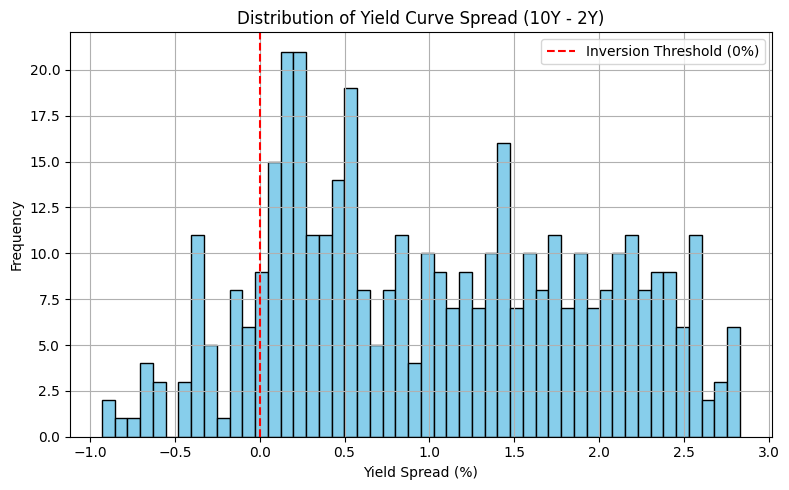

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(df['yield_spread'], bins=50, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', label='Inversion Threshold (0%)')
plt.title("Distribution of Yield Curve Spread (10Y - 2Y)")
plt.xlabel("Yield Spread (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

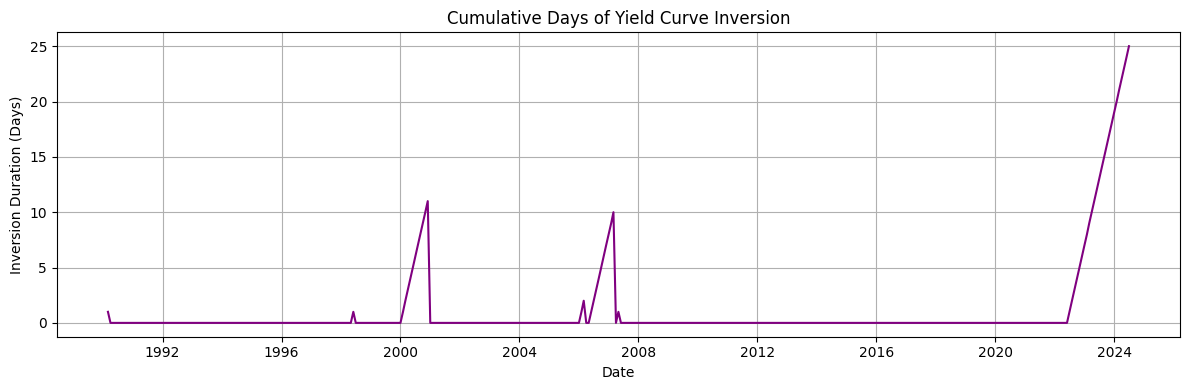

In [ ]:
df['inverted'] = df['yield_spread'] < 0
df['inversion_period'] = df['inverted'].astype(int).groupby((~df['inverted']).cumsum()).cumsum()

plt.figure(figsize=(12, 4))
plt.plot(df.index, df['inversion_period'], color='purple')
plt.title("Cumulative Days of Yield Curve Inversion")
plt.xlabel("Date")
plt.ylabel("Inversion Duration (Days)")
plt.grid(True)
plt.tight_layout()
plt.show()

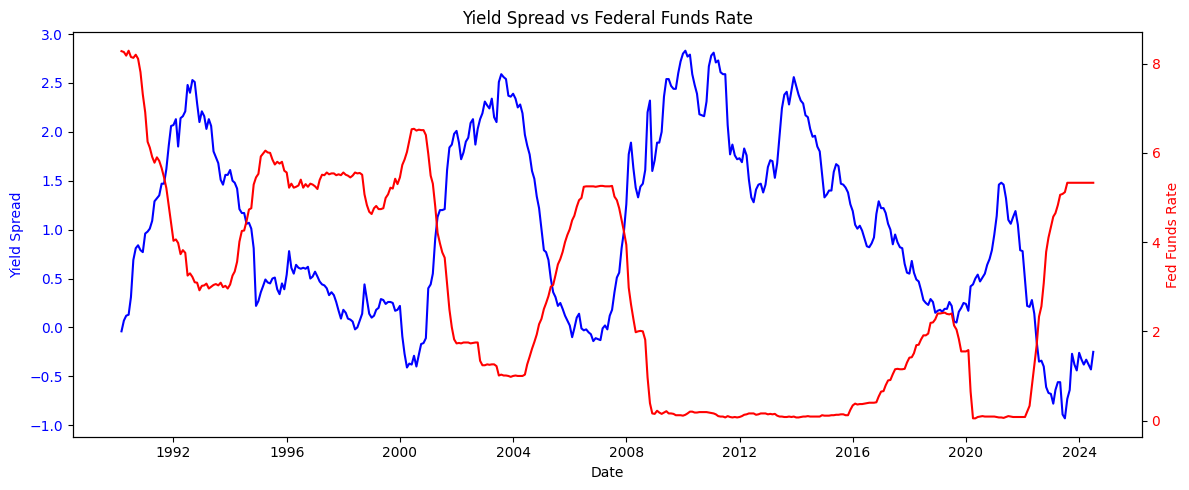

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.set_xlabel("Date")
ax1.set_ylabel("Yield Spread", color='blue')
ax1.plot(df.index, df['yield_spread'], label='Yield Spread', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel("Fed Funds Rate", color='red')
ax2.plot(df.index, df['fed_funds'], label='Fed Funds Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Yield Spread vs Federal Funds Rate")
fig.tight_layout()
plt.show()

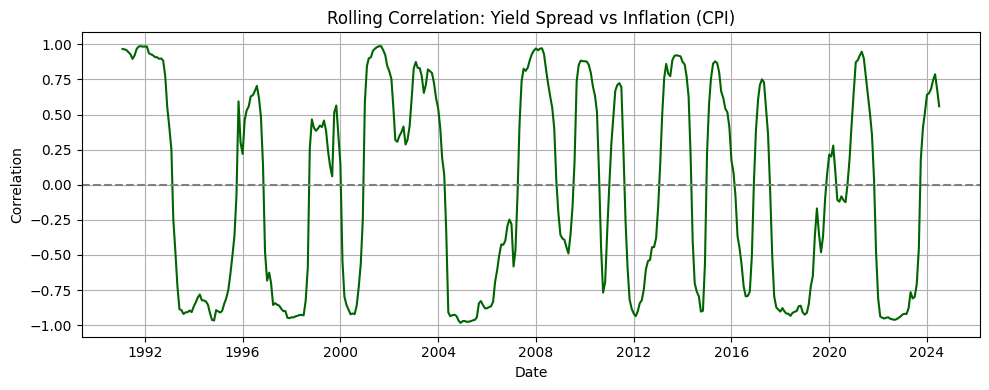

In [ ]:
rolling_corr = df['yield_spread'].rolling(12).corr(df['cpi'])

plt.figure(figsize=(10, 4))
plt.plot(df.index, rolling_corr, label='12-Month Rolling Correlation', color='darkgreen')
plt.title("Rolling Correlation: Yield Spread vs Inflation (CPI)")
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, color='orange', label='Predicted vs Actual', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'blue', linestyle='--', label='Perfect Prediction')

plt.xlabel("Actual Yield Spread")
plt.ylabel("Predicted Yield Spread")
plt.title("9. Actual vs Predicted Scatter")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'y_test' is not defined

<Figure size 600x600 with 0 Axes>